In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import multi_rake
import re
import string
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from multi_rake import Rake
import nltk
import csv
pd.options.mode.chained_assignment = None  # default='warn'


#deal with 2006~2012
path = '/Users/jiaruizhang/Desktop/reviews/AZ_Review/' # use your path
filename = []
for i in range(2010,2013,1):
    filename += [path+str(i)+'.csv']
AZ_review_before = pd.concat(map(pd.read_csv, filename))
#deal with 2013 special case
az_13org = pd.read_csv('/Users/jiaruizhang/Desktop/reviews/AZ_Review/2013.csv',engine ='python') 
az_2013 = az_13org.iloc[:30000,:11]
#merge result 
AZ_merge = [AZ_review_before,az_2013]
AZ_review = pd.concat(AZ_merge)
AZ_review = AZ_review.sort_index()
AZ_content = AZ_review.content
AZ_star = AZ_review.star
AZ_ID = AZ_review.user_id
AZ_content = AZ_content.to_frame()
AZ_star = AZ_star.to_frame()
AZ_ID = AZ_ID.to_frame()
frames = [AZ_ID,AZ_star,AZ_content]
AZ = pd.concat(frames,axis = 1, sort = True)

In [2]:
AZ

,user_id,star,content
0,A33EN2ZL2MS0CI,3,"Our Family Wedding is a good movie, just know ..."
0,A2YVJNYW60BH0N,5,"Witty ,funny,smart and very sexy .Just the rig..."
0,A3FU4UD3Q105YB,3,My 19 year old daughter bought this movie arou...
0,A1RRCDE10SUAXB,5,This show is extremely funny. I highly recomm...
1,A39WU6Z0GLFPZF,5,A very entertaining story of two different eth...
...,...,...,...
192342,AJE2898VBZRI8,5,This is the best DVD collection I have ever pu...
192343,A9BLACH3N9Y4,3,I started watching this show based on a recomm...
192344,A3QKZIXX7P5N5E,5,The other day I met Tom Welling and he signed ...
192345,AWPOWZJNQ2PHH,2,Greetings fellow amazonians I just wanted to w...


In [3]:
# skip last column
AZ.drop_duplicates(['user_id'])

,user_id,star,content
0,A33EN2ZL2MS0CI,3,"Our Family Wedding is a good movie, just know ..."
0,A2YVJNYW60BH0N,5,"Witty ,funny,smart and very sexy .Just the rig..."
0,A3FU4UD3Q105YB,3,My 19 year old daughter bought this movie arou...
0,A1RRCDE10SUAXB,5,This show is extremely funny. I highly recomm...
1,A39WU6Z0GLFPZF,5,A very entertaining story of two different eth...
...,...,...,...
192338,A2BPXHBAF8PVIV,5,"Love, love, love this collection! Can't get en..."
192340,A1YUCDM6Y43O73,5,Order was exactly what I wanted and shipped fa...
192341,A1KNXZUKP2KK7S,5,I'm delighted with the presentation!! The pics...
192342,AJE2898VBZRI8,5,This is the best DVD collection I have ever pu...


In [4]:
judge = AZ.duplicated(['user_id'])
type(judge)

pandas.core.series.Series

In [5]:
dup = 1-223168/393307
dup

0.43258574090977275

In [6]:
AZ_user = AZ['user_id'].value_counts().to_frame()
AZ_user = AZ_user[(AZ_user.user_id > 5)]
star = []
name = []
accum = 0
cnt = [] 
for row in AZ_user.iterrows():
    lis = AZ[(AZ.user_id == row[0])]
    score = lis['star'].astype(int).mean()
    star += [score]
    name += [row[0]]
    cnt += [row[1]]

df = pd.DataFrame(star,columns=['star'])
df['user_id'] = name
df['index'] = range(0,len(df)) 
df

,star,user_id,index
0,4.755020,A35ZK3M8L9JUPX,0
1,4.071138,A370Z6I5GBWU44,1
2,4.910515,AWG2O9C42XW5G,2
3,3.285714,ANCOMAI0I7LVG,3
4,3.996283,AV6QDP8Q0ONK4,4
...,...,...,...
6192,5.000000,AZJURZWT6TJBW,6192
6193,2.666667,AGDUM8DAAV8HA,6193
6194,4.166667,A2P0P6Z7YMZZK0,6194
6195,5.000000,ASJYEAVAWQ7H3,6195


In [7]:
avg = df['star'].mean()
avg # avg for AZ is 4.374

4.108854528557055

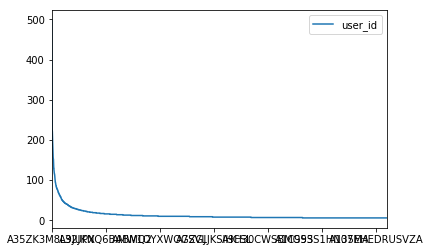

In [8]:
AZ_user = AZ['user_id'].value_counts().to_frame()
AZ_user = AZ_user[(AZ_user.user_id > 5)]
AZ_user.plot()
#new = AZ_user['user_id'].value_counts().to_frame()
#new = new[(new.user_id > 3)]
#new.plot(kind='bar')

In [9]:
AZ_user

,user_id
A35ZK3M8L9JUPX,498
A370Z6I5GBWU44,492
AWG2O9C42XW5G,447
ANCOMAI0I7LVG,322
AV6QDP8Q0ONK4,269
...,...
AZJURZWT6TJBW,6
AGDUM8DAAV8HA,6
A2P0P6Z7YMZZK0,6
ASJYEAVAWQ7H3,6


In [10]:
6197/393307

0.01575613960595667